In [13]:
from PIL import Image
from PIL import ImageChops
import numpy as np
from copy import deepcopy

In [14]:
#medianフィルタ処理で使う関数群ーモノクロとカラー画像に対応
def sort_row(array):
    
    if len(array.shape) == 3:    
        for row in np.arange(0, array.shape[0]):
            for col in np.arange(0, array.shape[1]):
                for col_cmp in np.arange(0, col):
                    if array[row, col, 0] > array[row, col_cmp, 0]:
                        array[row, col, :], array[row, col_cmp, :] = deepcopy(array[row, col_cmp, :]), deepcopy(array[row, col, :])
    elif len(imgarray.shape) == 2 :
         for row in np.arange(0, array.shape[0]):
            for col in np.arange(0, array.shape[1]):
                for col_cmp in np.arange(0, col):
                    if array[row, col] > array[row, col_cmp]:
                        array[row, col], array[row, col_cmp] = deepcopy(array[row, col_cmp]), deepcopy(array[row, col])
    else:
        raise Exception("argument must be 3 or 2 axis array!")
                    
            
def sort_col(array):
        
    if len(array.shape) == 2: 
        for row in np.arange(0, array.shape[0]):
            for row_cmp in np.arange(0, row):
                if array[row, 0] > array[row_cmp, 0]:
                    array[row, :], array[row_cmp, :] = deepcopy(array[row, :]), deepcopy(array[row_cmp, :])
    elif len(array.shape) == 1 :
        for row in np.arange(0, array.shape[0]):
            for row_cmp in np.arange(0, row):
                if array[row] > array[row_cmp]:
                    array[row], array[row_cmp] = deepcopy(array[row]), deepcopy(array[row_cmp])
    else:
        raise Exception("argument must be 3 or 2 axis array!")      
     
    
##メディアンフィルタ。axis=で選択された軸から先にソートする
def medianfilter(srcimg, dstimg, axis=1):
    
    if axis==1 :

        colsum = srcimg.shape[1]-6
        for col in np.arange(3, srcimg.shape[1]-3):
            #進捗％を出力
            print("\r{0:d}% progress...".format(int(col*100/colsum)), end="")
            for row in np.arange(3, srcimg.shape[0]-3):

                #ウィンドウ部分を行列に抽出
                window = deepcopy(srcimg[row-3:row+4, col-3:col+4])

                #フィルタウィンドウを行でソートする
                sort_row(window)

                #ウィンドウの3列目(各行の中央値)を抽出
                medians_row = deepcopy(window[:,3])

                #列でソートする
                sort_col(medians_row)

                #中央値を抽出・書き込み
                dstimg[row,col] = deepcopy(medians_row[3])
    
    elif axis==0 :    
        colsum = srcimg.shape[1]-6
        for col in np.arange(3, srcimg.shape[1]-3):
            #進捗％を出力
            print("\r{0:d}% progress...".format(int(col*100/colsum)), end="")
            for row in np.arange(3, srcimg.shape[0]-3):

                #ウィンドウ部分を行列に抽出
                window = deepcopy(srcimg[row-3:row+4, col-3:col+4])
                
                #転置
                window = np.transpose(window,(1,0))

                #フィルタウィンドウを行でソートする
                sort_row(window)
                
                #ウィンドウの3列目(各行の中央値)を抽出
                medians_row = deepcopy(window[:,3])

                #列でソートする
                sort_col(medians_row)

                #中央値を抽出・書き込み
                dstimg[row,col] = deepcopy(medians_row[3])
        

def prewittfilter(srcimg, dstimg):
    colsum = srcimg.shape[1]-6
    for col in np.arange(3, srcimg.shape[1]-3):
        #進捗％を出力
        print("\r{0:d}% progress...".format(int(col*100/colsum)), end="", flush=True)
        for row in np.arange(3, srcimg.shape[0]-3):

            #ウィンドウを抽出
            window = deepcopy(srcimg[row-1:row+2, col-1:col+2])

            #ウィンドウとprewittフィルタを要素ごとに掛け合わせて足し、絶対値をとる
            dx = np.multiply(window, prewitt_x).sum()
            dy = np.multiply(window, prewitt_y).sum()
            #渡部：FPGA上の実装と合わせました。
            #---------------変更点はここから--------------------
            dx /= 4.0
            dy /= 4.0
            # dstimg[row, col, :] = np.sqrt(dx * dx + dy * dy)
            dstimg[row, col] = (abs(dx) + abs(dy)) / 2
            #----------------ここまで-----------------------------
            ##境界線抽出 !!本来のSobelフィルタの機能にはない操作 きょっきょが勝手に追加した
            #dxy = 255 - (dx + dy)
            #dstimg[row, col, :] = dxy if (dxy < 50) else 255
            
prewitt_x = np.array([
    [-1, 0, 1],
    [-1, 0, 1],
    [-1, 0, 1]    
])

prewitt_y = np.array([
    [-1, -1, -1],
    [ 0,  0,  0],
    [ 1,  1,  1]    
])

In [15]:
# 処理のための準備

## 画像読み込み
img = Image.open("sample5.jpg")
## モノクロ画像に変換
img = img.convert('L')

## 画像の周りに3pxのパディングを追加
imgarray = np.asarray(img)
for i in np.arange(0,3):
    imgarray = np.insert(imgarray, 0, 0, 0)
for i in np.arange(0,3):
    imgarray = np.insert(imgarray, 0, 0, 1)
for i in np.arange(0,3):
    imgarray = np.insert(imgarray, imgarray.shape[1], 0, 1)
for i in np.arange(0,3):
    imgarray = np.insert(imgarray, imgarray.shape[0], 0, 0)

In [16]:
# メディアンフィルタモジュール

## フィルタ後の画像を書き込むため、imgarrayのコピーを作成
imgarray_median_col = deepcopy(imgarray)
## 各ピクセルについて7×7メディアンフィルタをかける
medianfilter(imgarray, imgarray_median_col, axis=1)


## フィルタ後の画像を書き込むため、imgarray_median_colのコピーを作成
imgarray_median_row = deepcopy(imgarray_median_col)
## 各ピクセルについて7×7メディアンフィルタをかける
medianfilter(imgarray_median_col, imgarray_median_row, axis=0)


100% progress...

In [31]:
# prewittフィルタモジュール

## フィルタ後の画像を書き込むため、imgarray_medianのコピーを作成
imgarray_median_prewitt = deepcopy(imgarray_median_row)

## 各ピクセルについて3×3 prewittフィルタをかける
prewittfilter(imgarray_median_row, imgarray_median_prewitt)

100% progress...

In [32]:
## Sobelの出力結果のうち、しきい値を超えた部分を白にしてしまう
imgarray_median_prewitt_thresh = deepcopy(imgarray_median_prewitt)
for col in np.arange(0, imgarray_median_prewitt.shape[1]):
    for row in np.arange(0, imgarray_median_prewitt.shape[0]):
        if imgarray_median_prewitt[row][col] < 10: ##←しきい値
            imgarray_median_prewitt_thresh[row][col] = 0
        
            
###↓↓この値はmedian+sobelの出力結果にかけるための値です。これを大きくすると輪郭画像の輪郭が濃くなる
PREWITT_STRENGTH = 2

# 配列を画像へ
img_original = Image.fromarray(imgarray)
img_median = Image.fromarray(imgarray_median_row)
img_med_prewitt = Image.fromarray((imgarray_median_prewitt_thresh)*PREWITT_STRENGTH)

# 画像の合成

## 比較（暗）合成…画像を比較して暗い方を採用
#img_composited = ImageChops.darker(img_median, img_med_sobel) 
## 減算合成…画像1の画素値から画像2の画素値を引く
img_composited = ImageChops.subtract(img_median, img_med_prewitt) 
                                   

## [渡部]マスク用のImageを作って合成
#ref:https://note.nkmk.me/python-pillow-composite/
# mask = Image.new("L", Image.fromarray(imgarray).size,  145 )
#result = composte(img1, img2, mask) は以下と等価。
#result = mask / 255 * image1 + (1 - mask / 255 ) * image2
#img_composited = Image.composite(Image.fromarray(imgarray_median), Image.fromarray(255 - imgarray_median_sobel),mask)

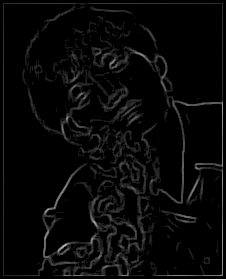

In [33]:
img_med_prewitt

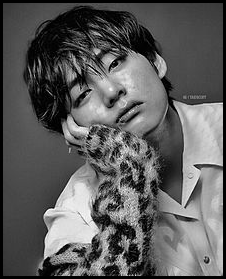

In [34]:
img_original

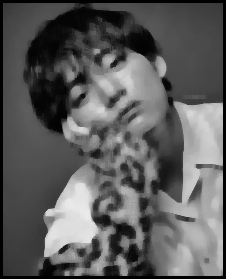

In [35]:
img_median

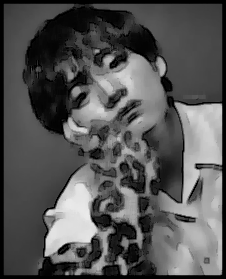

In [36]:
img_composited